# Advanced Lane Finding Project

The tasks to accomplish in this project are as following:

 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
 2. Apply a distortion correction to raw images.
 3. Use color transforms, gradients, etc., to create a thresholded binary image.
 4. Apply a perspective transform to rectify binary image ("birds-eye view").
 5. Detect lane pixels and fit to find the lane boundary.
 6. Determine the curvature of the lane and vehicle position with respect to center.
 7. Warp the detected lane boundaries back onto the original image.
 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
# Import necessary packages
import os
import numpy as np
import glob # to read files from dir
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

os.getcwd()

'C:\\Jandal\\workspace_P\\UNDSC\\CarND-Advanced-Lane-Lines'

### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
The solution can be found in <font color=blue>1_Camera_Calibration.ipynb</font> notebook in this directory.

### 2. Apply a distortion correction to raw images.

In [2]:
# Reading camera calibration variables from pickle object
path_dir = os.getcwd()+"\\pickled_data\\"
pickle_obj = pickle.load(open(path_dir+"camera_calibration.p", "rb" ))
mtx = pickle_obj["mtx"]
dist = pickle_obj["dist"]

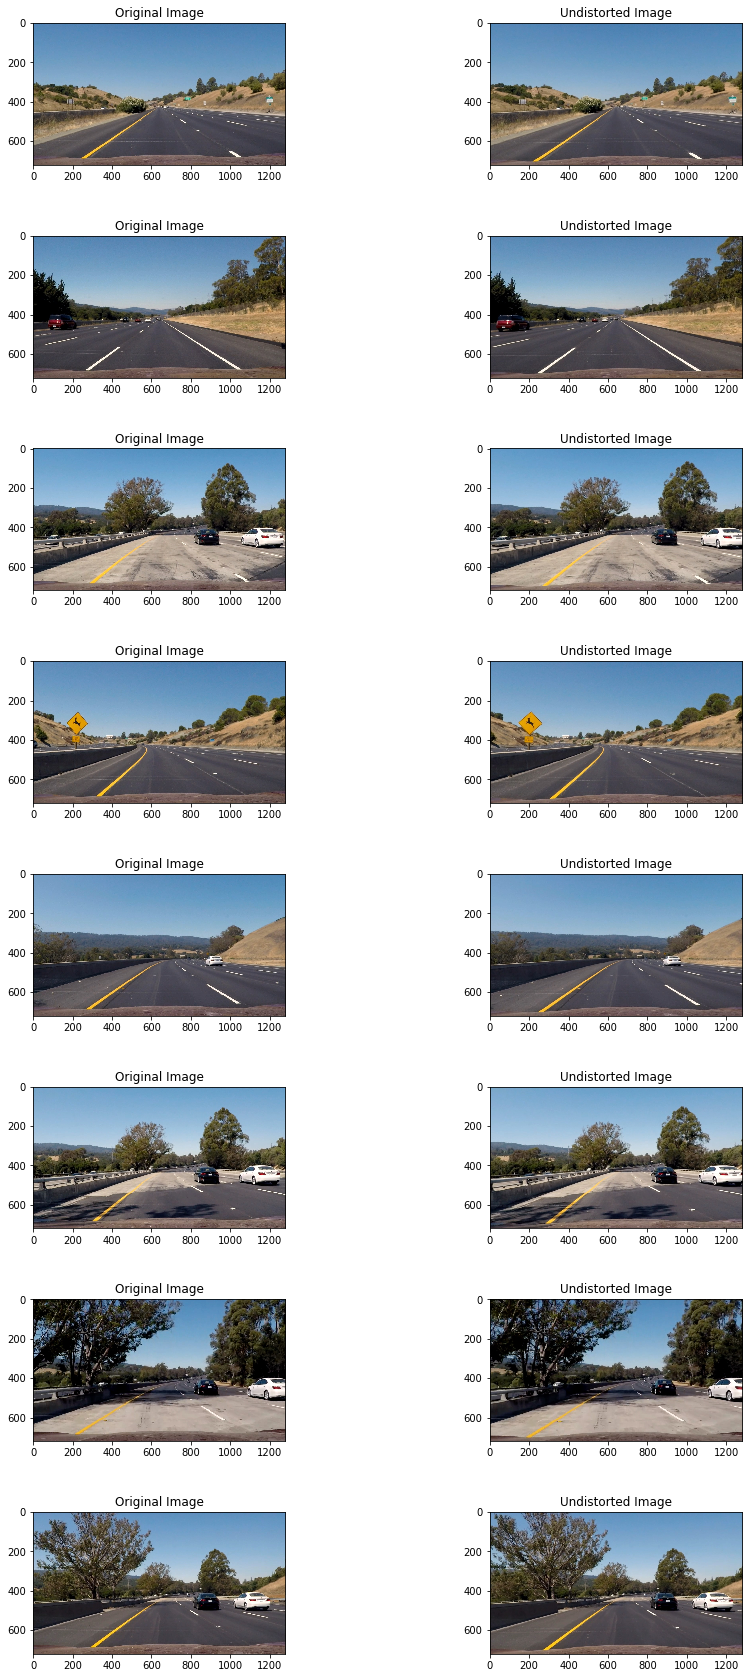

In [3]:
###==================================================
# 0. Undistort test images
###==================================================

# Defining Figure dimensions
fig_rows = 8 # As there are 8 test images in ../test_images/
fig_cols = 2
f, axes= plt.subplots(fig_rows,fig_cols,figsize=(15,30))
f.subplots_adjust(hspace=0.5)

path_dir = os.getcwd()+"\\test_images\\"
test_images = glob.glob(path_dir+"*.jpg")

for i, img in enumerate(test_images):
    dist_img = mpimg.imread(img)
    axes[i,0].imshow(dist_img)
    axes[i,0].set_title("Original Image")
    undist_img = cv2.undistort(dist_img, mtx, dist, None, mtx) # undistorting image 
    cv2.imwrite('output_images/test_img_undistorted_'+str(i)+'.jpg', cv2.cvtColor(undist_img,cv2.COLOR_BGR2RGB))    
    axes[i,1].set_title("Undistorted Image")
    axes[i,1].imshow(undist_img)

### 3. Use color transforms, gradients, etc., to create a thresholded binary image.

In [4]:
###==================================================
# 1. Applying Sobel x
###==================================================

# In the following cases I will only take 1 example image for elaboration

# Read a test image
path_dir = os.getcwd()+"\\test_images\\"
original_image = mpimg.imread(path_dir+"test6.jpg")

# Visualization function to be used in the following stages
def plot_the_result(original_image,result_img,t1="Original Image", t2="Thresholded"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
    f.tight_layout()
    ax1.imshow(original_image)
    ax1.set_title(t1, fontsize=30)
    ax2.imshow(result_img, cmap='gray')
    ax2.set_title(t2, fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

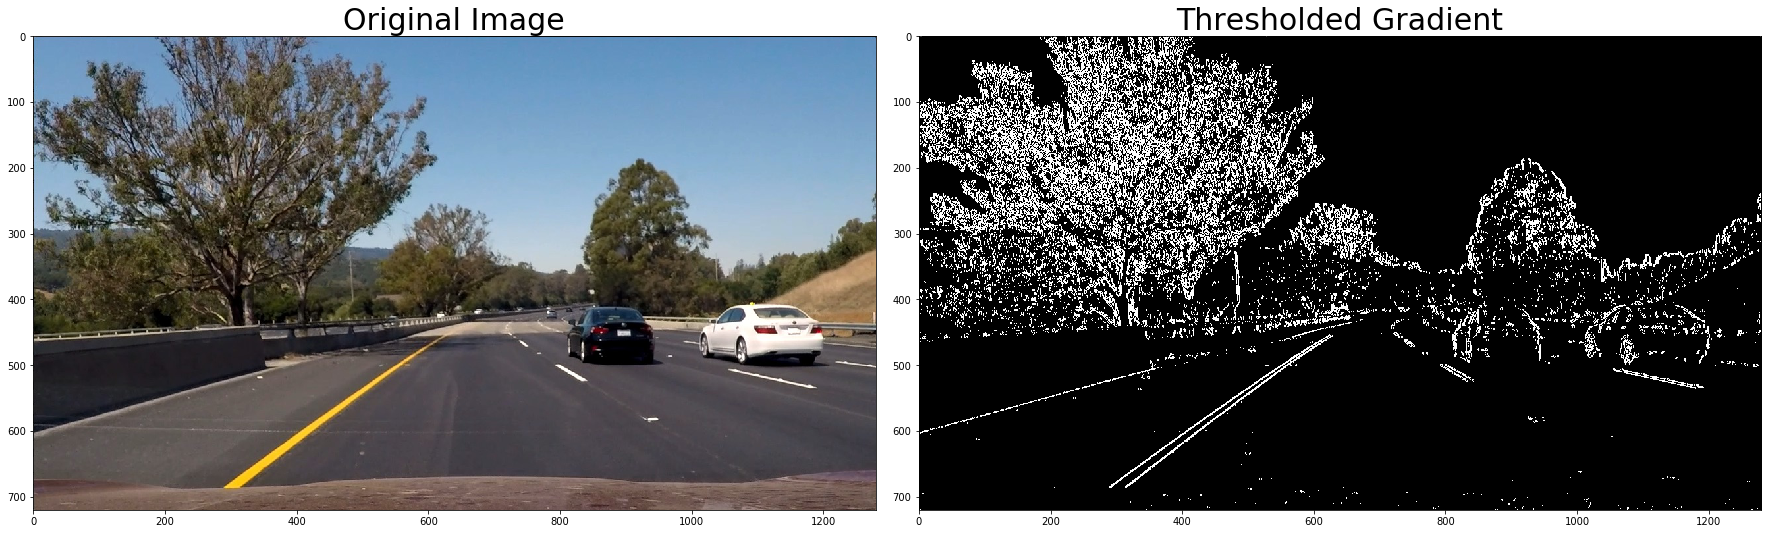

In [5]:
# Function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if(orient == 'x'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return sbinary

# Hyper params
ORIENT = 'x'
THRESH_MIN = 20
THRESH_MAX = 100

thrshd_img = abs_sobel_thresh(original_image, 
                              orient=ORIENT, 
                              thresh_min=THRESH_MIN, 
                              thresh_max=THRESH_MAX)

# Plot the result
plot_the_result(original_image, thrshd_img, t2="Thresholded Gradient")

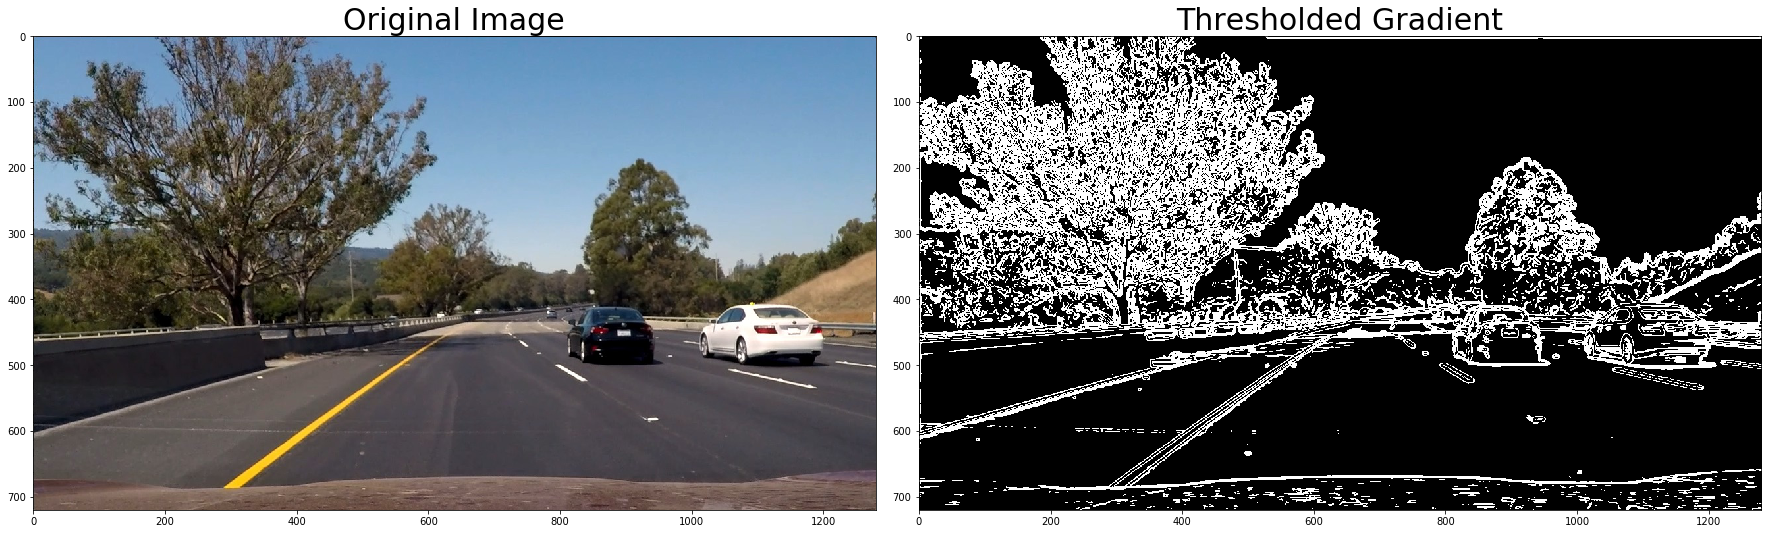

In [6]:
###==================================================
# 2. Magnitude of the gradient
###==================================================

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobelxy = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    sbinary = np.zeros_like(scaled_sobelxy)
    sbinary[(scaled_sobelxy >= mag_thresh[0]) & (scaled_sobelxy <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sbinary

# Hyper params
SOBEL_KERNEL = 9
THRESH_MIN = 20
THRESH_MAX = 100

mag_binary = mag_thresh(original_image,
                        sobel_kernel=SOBEL_KERNEL, 
                        mag_thresh=(THRESH_MIN, THRESH_MAX))

# Plot the result
plot_the_result(original_image, mag_binary, t2="Thresholded Gradient")

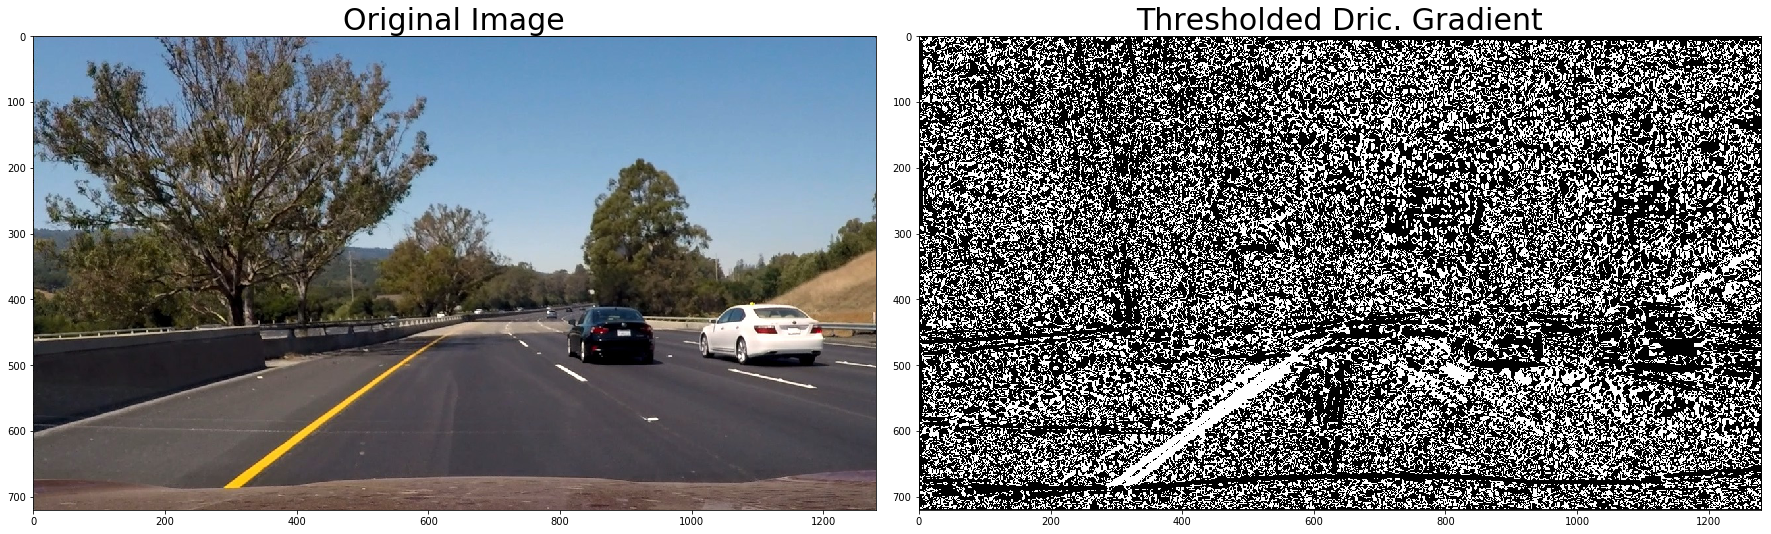

In [7]:
###==================================================
# 3. Direction of the gradient
###==================================================

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    return binary_output

# Hyper params
SOBEL_KERNEL = 17
THRESH_MIN = 0.7
THRESH_MAX = 1.3

dir_binary = dir_threshold(original_image,
                           sobel_kernel=SOBEL_KERNEL,
                           thresh=(THRESH_MIN, THRESH_MAX))

# Plot the result
plot_the_result(original_image, dir_binary, t2="Thresholded Dric. Gradient")

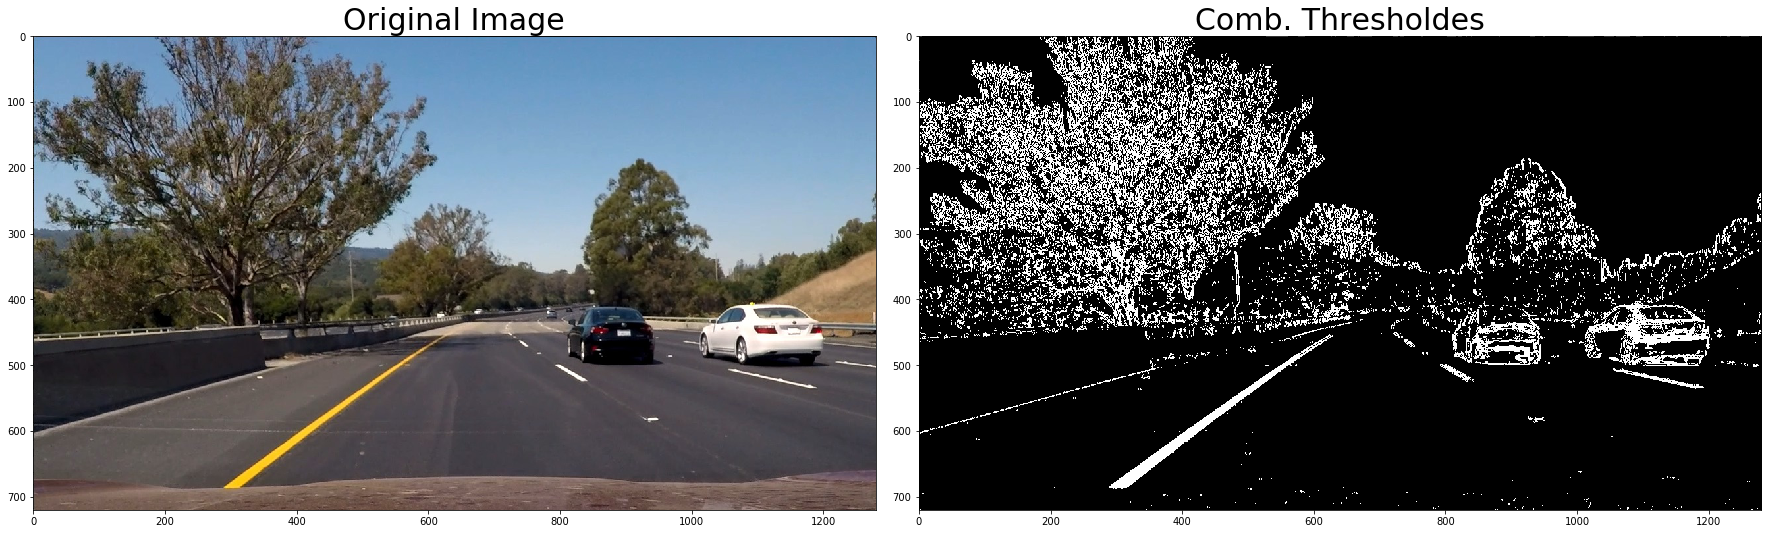

In [8]:
###==================================================
# 4. Combining Thresholds
###==================================================
# Combining thresholds: The code is taken from lessons
def get_binarized(original_image):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(original_image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    gray = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

# Plot the result
combined_img = get_binarized(original_image)
plot_the_result(original_image, combined_img, t2="Comb. Thresholdes")

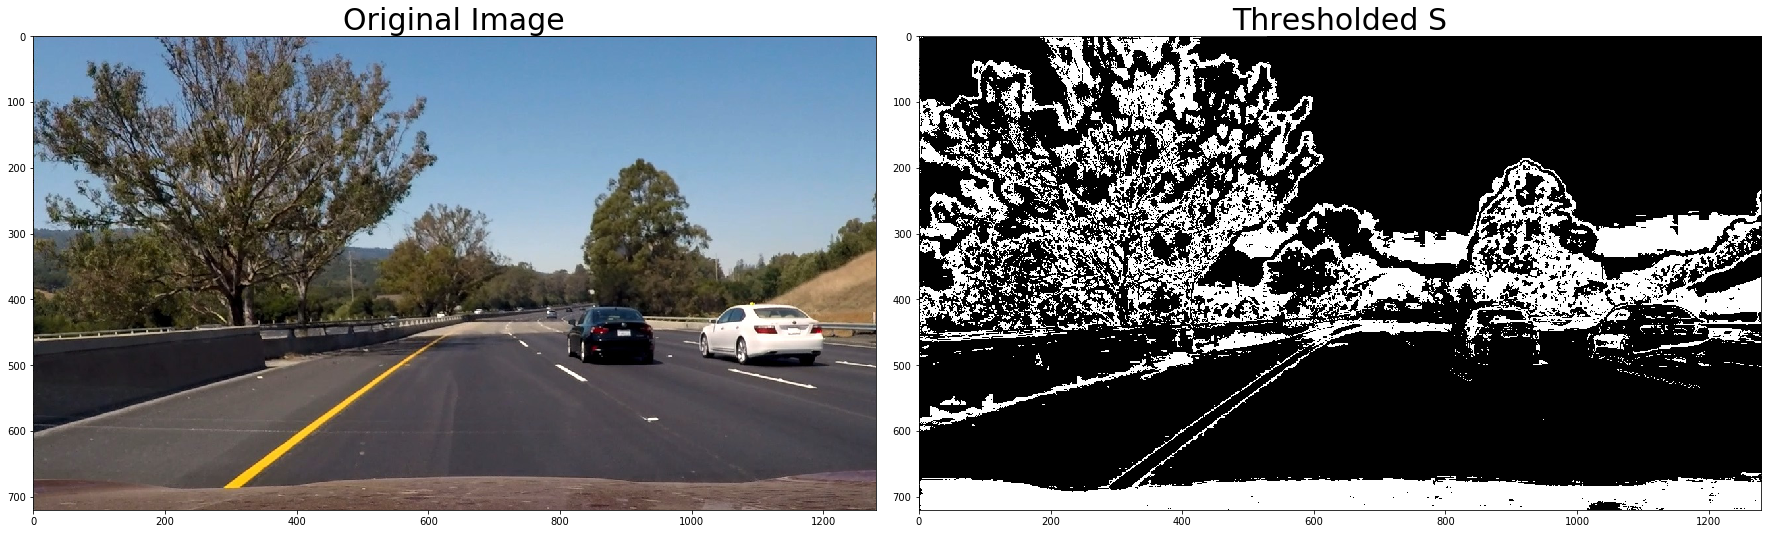

In [9]:
###==================================================
# 5. HLS Color Threshold
###==================================================

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

# Plot the result
hls_binary = hls_select(original_image, thresh=(30, 80))

plot_the_result(original_image, hls_binary, t2="Thresholded S")

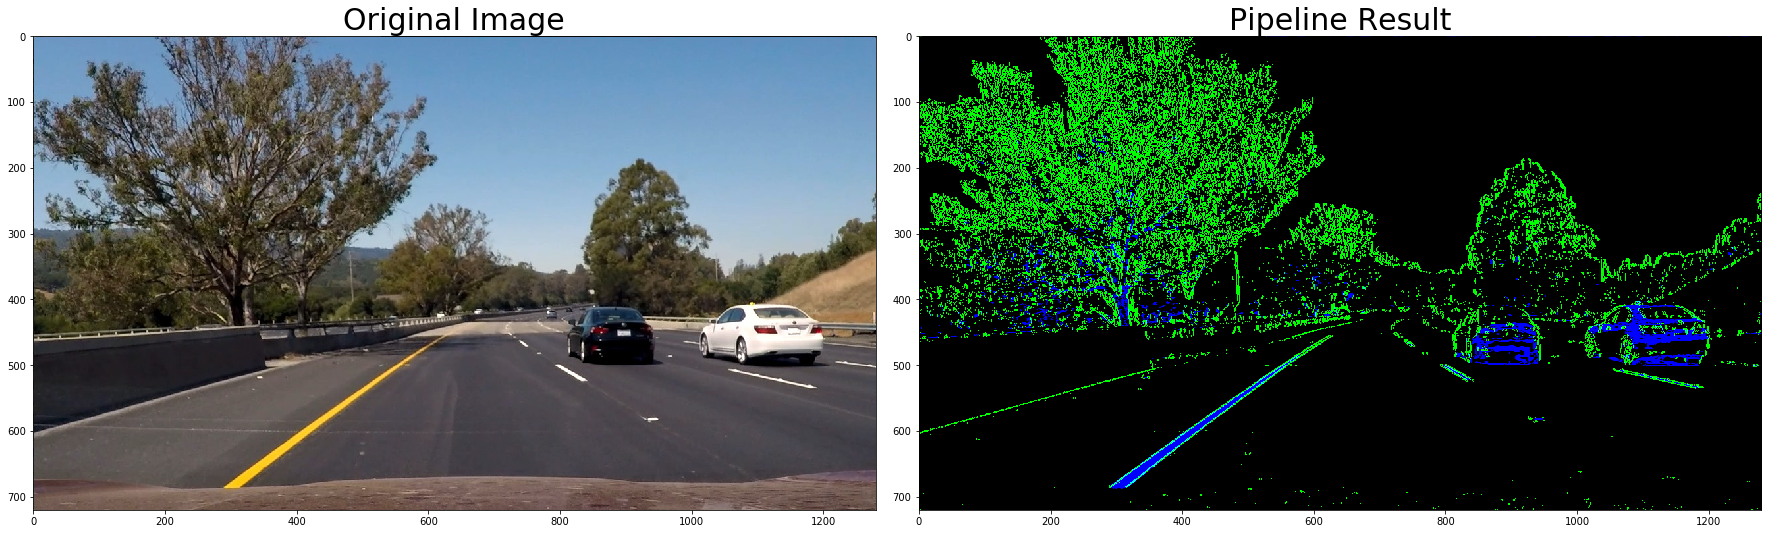

In [10]:
###==================================================
# 6. Combining Color and Gradient Thresholding
###==================================================

# Function to create pipeline of 
# combination of color and gradient thresholding
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    return color_binary

# Plot the result
result = pipeline(original_image)

plot_the_result(original_image, result, t2="Pipeline Result")

### 4. Apply a perspective transform to rectify binary image ("birds-eye view").

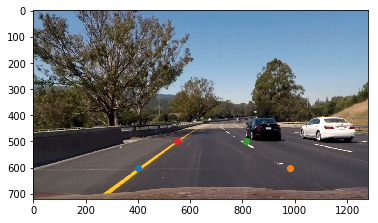

In [11]:
###==================================================
# Perspective transformation
###==================================================

# Step 1: Undistort the given image
undist_img = cv2.undistort(original_image, mtx, dist, None, mtx) # undistorting image 

# Source image points
plt.imshow(undist_img)
bottom_left = [400, 600]
bottom_right = [980, 600]
top_right = [815, 500]
top_left = [550, 500]

plt.plot(bottom_left[0], bottom_left[1], "o") # bottom left point
plt.plot(bottom_right[0], bottom_right[1], "o") # bottom right point
plt.plot(top_right[0], top_right[1], "o") # top right point
plt.plot(top_left[0], top_left[1], "o") # top left point

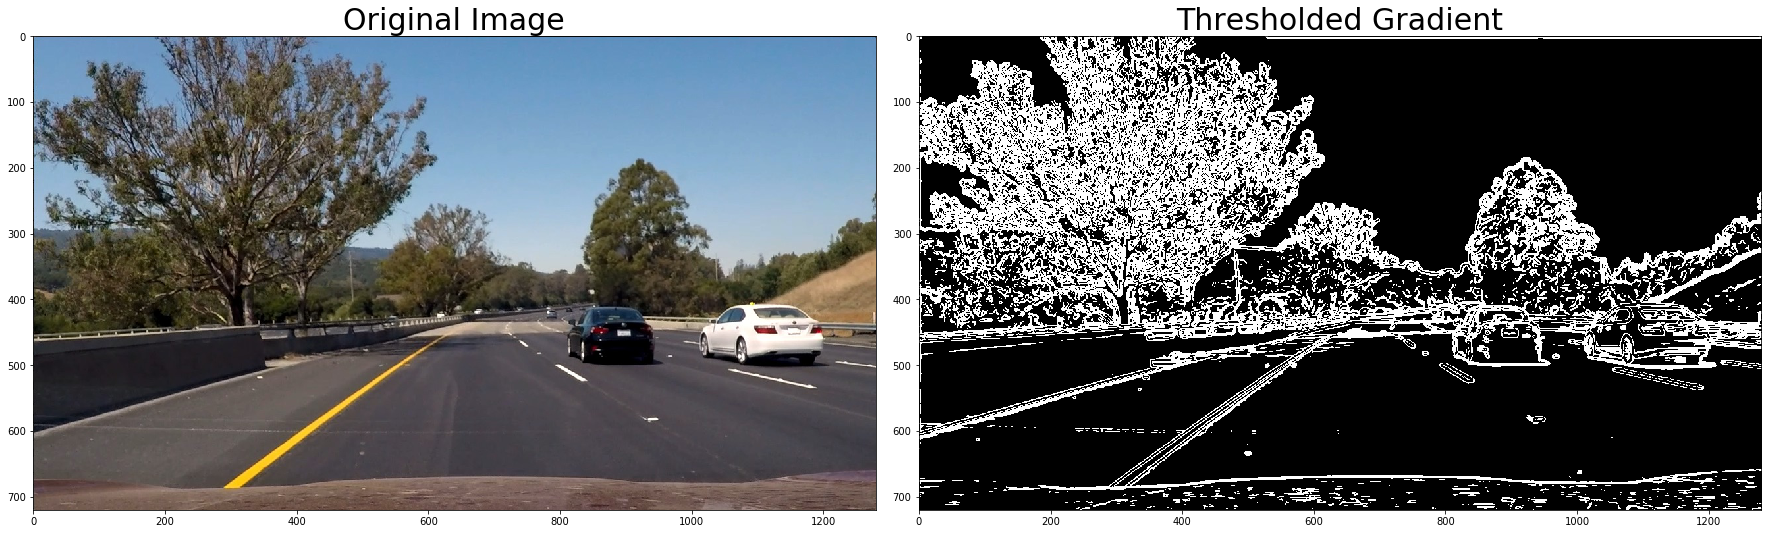

In [12]:
# Applying thresholds to rectify binary image
# Hyper params
SOBEL_KERNEL = 9
THRESH_MIN = 20
THRESH_MAX = 100
mag_binary = mag_thresh(original_image,
                        sobel_kernel=SOBEL_KERNEL, 
                        mag_thresh=(THRESH_MIN, THRESH_MAX))

# Plot the result
plot_the_result(original_image, mag_binary, t2="Thresholded Gradient")

False

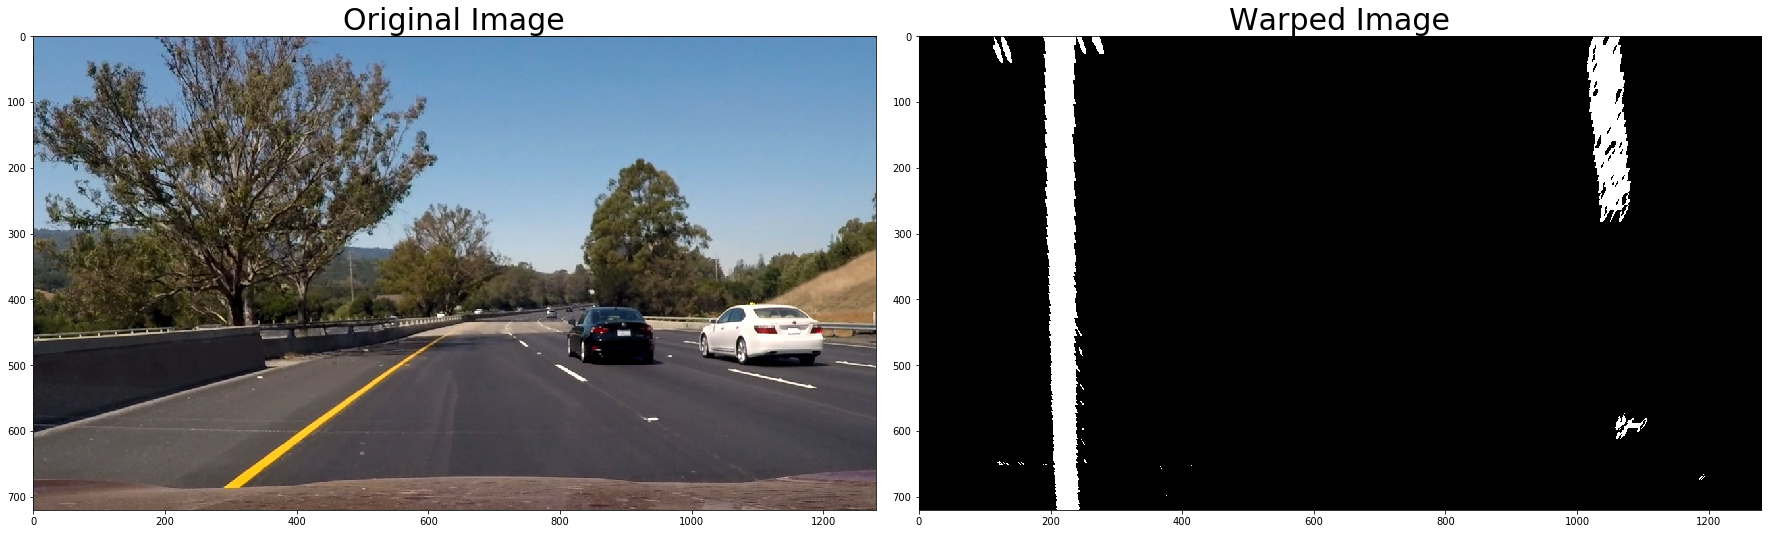

In [15]:
# Perspective transformation
def WarpPerspective(image, src, dst):
    y=image.shape[0]
    x=image.shape[1]
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(image, M, (x, y), flags=cv2.INTER_LINEAR)

# Source & destination image points
src = np.float32([[400, 600], [980, 600], [815, 500], [550, 500]])
#dst = np.float32([[200, 600], [980, 600], [980, 0], [200, 0]])
#dst = np.float32([[200, 650], [980, 650], [980, 250], [200, 250]])
#dst = np.float32([[200, 630], [980, 630], [980, 250], [200, 250]])
dst = np.float32([[200, 650], [1100, 650], [1100, 20], [200, 20]])

wrapPerspective = WarpPerspective(combined_img, src, dst)

# Plot the result
plot_the_result(original_image, wrapPerspective, t2="Warped Image")

In [14]:
# Writing the images to pickle object
# Pickle dump
pickle_path = os.getcwd()+'\\pickled_data\\result_images.p'
pickle.dump( { 'original_image': original_image, 
              'combined_img': combined_img,
              'wrapPerspective': wrapPerspective}, open(pickle_path, 'wb'))